# Lab 2 - Cross validation 
## Hesam Mohebi & Bahaar Khalilian

The following functions are the implementation  of the KNN algorithm for classification problems

In [1]:
# Packages used
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

In [2]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = (np.random.rand(n, 2) * (high_D - low_D)) + low_D
    Y = np.sign((X[:,1] - (m * X[:,0]) + q))
    Y[Y==0] = 1
    return X,Y

In [3]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [4]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

In [5]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        raise Exception('P should be between 1 and 100')
        
    indices_to_flip = np.random.choice(range(len(Y)), int(len(Y) * (P / 100)), replace=False)
    Y_noisy = Y.copy()
    Y_noisy[indices_to_flip] *= -1
    
    return Y_noisy


In [6]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from test input and training input
    dist = allDistances(Xte, Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # All the distances for the current test point
        idx_dist = dist[idx]
        # Sorting the indices of the distances
        order_idx_dist = np.argsort(idx_dist)
        
        # Getting the k lowest distence's indices
        k_idx_dist = order_idx_dist[:k]
        # Computing the mean of the output values of the corresponding training points and taking the sign of it.
        Ypred[idx] = np.sign(np.mean(Ytr[k_idx_dist]))
    return Ypred


In [7]:
def separatingFkNN(Xtr, Ytr, k, Xte):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 500)
    yi = np.linspace(y.min(), y.max(), 500)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    #plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==1], y[Ytr==1], c="#C59434", marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==-1], y[Ytr==-1], c="#092C48", marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    #msg = 'Separating function, k='+str(k);
    #plt.title(msg)

In [8]:
def plotData(Xtr, Ytr):
    x = Xtr[:, 0]
    y = Xtr[:, 1]
    plt.scatter(x[Ytr==1], y[Ytr==1], c="#C59434", marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==-1], y[Ytr==-1], c="#092C48", marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())


In [9]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

## Cross-validation
In this Lab, we focus on Cross-validation for model selection.

### Preliminaries: Data-loading

There are 4 datasets included with this lab, with the following properties:

  - (Training1, Test1): n=70, no noise, suggested K values are in the range 1 ... 13
  - (Training2, Test2): n=40, no noise, suggested K values are in the range 1 ... 23
  - (Training3, Test3): n=200, 20% flipped labels, suggested K values are in the range 1 ... 31
  - (Training4, Test4): n=200, 5% flipped labels, suggested K values are in the range 1 ... 19

Note that each dataset includes both a training and a test set. You **cannot use the test set to choose k**: you should assume you don't have access to the test set when doing model selection!

To load a dataset use function
`Xtr, Ytr, Xte, Yte = load_dataset(path_tr, path_te)`

Where:
- **_path\_tr_**: is the path to the file which contains the training set
- **_path\_te_**: is the path to the file which contains the test set

and it returns:
- **_Xtr_**: Inputs of training set
- **_Ytr_**: Outputs of training set
- **_Xte_**: Inputs of test set
- **_Yte_**: Outputs of test set

In [ ]:
### If you use colab uncomment these line and upload Material.zip

#from google.colab import files

#files.upload()
#!unzip Material.zip

In [10]:
def load_dataset(path_tr, path_te):
    with open(path_tr,"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    with open(path_te,"rb") as f:
        [Xte, Yte] = pickle.load(f)
    return Xtr, Ytr, Xte, Yte

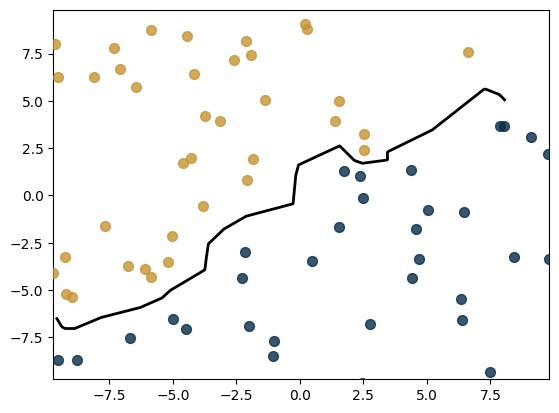

In [12]:
training_set_path = "./Material/Classification/Training1.dat"
test_set_path = "./Material/Classification/Test1.dat"
Xtr, Ytr, Xte, Yte = load_dataset(training_set_path, test_set_path)
separatingFkNN(Xtr, Ytr, 1, Xtr)

## Using the training set to choose k

Having noted that we cannot directly use the test set to find the best k, we can try to select it with the training set. 
Follow these steps, and fill in the blanks in the following cells. **Comment on your findings in the notebook**.

 1. Choose a list of values for k you want to try. Check the list of suggested values for any given dataset.
 2. For each value of k do:
     1. Train a k-NN classifier with the current value of k
     2. Evaluate the error of the trained model, **on the training set**
 3. The _best_ k is the one with the lowest training error!
 4. Train a k-NN model with the chosen k, and evaluate the error **on the test set**. Is the test error similar to the training error? Does the chosen k seem like a good one?

In [46]:
# Use dataset 1 for this task.
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training1.dat", "./Material/Classification/Test1.dat")
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

k_tr_errors = []
for current_k in k_list:
    Ypred = kNNClassify(Xtr, Ytr, current_k, Xtr)
    current_tr_err =  calcError(Ypred, Ytr)
    k_tr_errors.append(current_tr_err)
    
best_k =  np.argsort(k_tr_errors)[0] + 1 # since the index start from 0 each k is one value higher the its index

print(f"The best k chosen with the training-set is: {best_k}\n"
      f"with training error {np.min(k_tr_errors)*100:.2f}%")


The best k chosen with the training-set is: 1
with training error 0.00%


In [47]:
# Evaluate the model with the best k on the test set now

Ypred = kNNClassify(Xtr, Ytr, best_k, Xte)
te_err = calcError(Ypred, Yte)
    
print(f"The test error with the best k ({best_k}) is: {te_err*100:.2f}%")

The test error with the best k (1) is: 7.14%


Text(0.5, 1.0, 'Choosing k from the training set.')

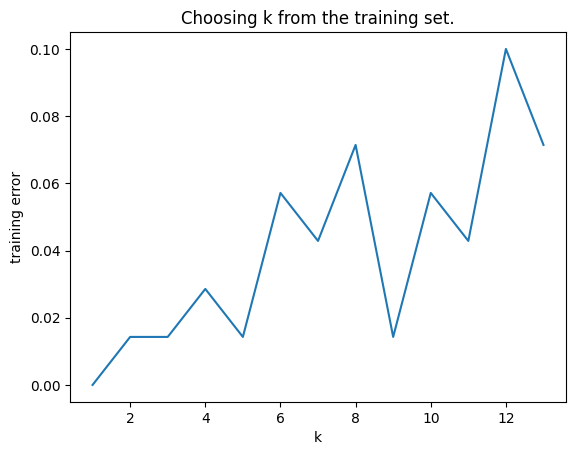

In [48]:
# Plot how the training error changes with k
fig, ax = plt.subplots()
ax.plot(k_list, k_tr_errors)
ax.set_xlabel("k")
ax.set_ylabel("training error")
ax.set_title("Choosing k from the training set.")

#### Observations:

- The k chosen was k=1 because since we are training and testing on the training data, the closest points are themselves and the error is zero.

- When we apply this training with k=1 on the test data, this performs poorly (12% of error). So the k is a very bad choice, it is overfitting the training data.

## K-Fold cross validation

The training error does not provide good estimates of the test error. So using the training error for model selection means you will select a k which is not good for the test set.

A simple way, which is much better than the training error, to estimate the test error is to use a **k-fold cross validation**. In K-Fold cross validation, the data are split into K parts of approximately equal size, and K different models are trained each time leaving out one of the parts of data. Then the estimate for the test error is the mean of the error of the K different models.

In this task you will implement K-Fold CV, and run the same analysis as in the previous cell.

In [81]:
def KFoldCVkNN(Xtr, Ytr, num_folds, hyperparam_list):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - hyperparam_list : List[int]
         the values of k (for k-NN) to try.
         
    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rnd_state = np.random.RandomState()
    # Ensures that k_list is a numpy array
    hyperparam_list = np.array(hyperparam_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        

        for k_idx, current_k in enumerate(hyperparam_list):
            # TODO: Compute the training error of the kNN classifier for the given value of k
            ypred_train = kNNClassify(x_train, y_train, current_k, x_train)
            tr_errors[k_idx, fold_idx] = calcError(ypred_train, y_train)
            # TODO: Compute the validation error of the kNN classifier for the given value of k
            ypred_val = kNNClassify(x_train, y_train, current_k, x_val)
            val_errors[k_idx, fold_idx] = calcError(ypred_val, y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.where(k_list == best_k)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [120]:
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test1.dat")

num_folds = 5
k_list = range(1, 19, 2)
best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
    Xtr, Ytr, num_folds, k_list)

print(f"The best k chosen with {num_folds} folds is {best_k} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

The best k chosen with 5 folds is 13 with error 5.50 +- 1.87%


### Plot the training and validation error with the K

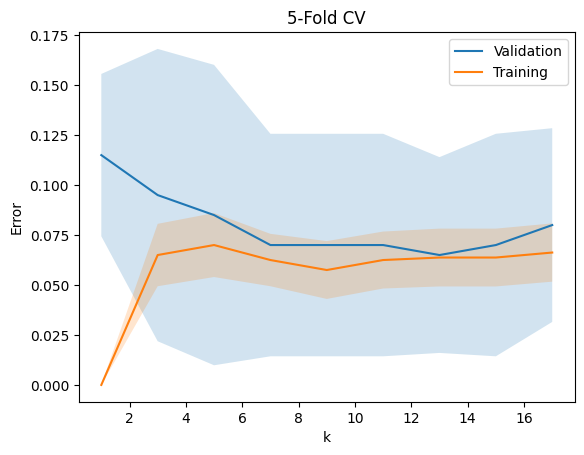

In [83]:
fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_title(f"{num_folds}-Fold CV")
ax.set_ylabel("Error")
ax.set_xlabel("k")
ax.legend()

In [84]:
# Evaluate the model with the best k on the test set now
Ypred = kNNClassify(Xtr, Ytr, best_k, Xte)
te_err = calcError(Ypred, Yte)
    
print(f"The test error with the best k ({best_k}) is: {te_err*100:.2f}%")

The test error with the best k (13) is: 0.00%


## Cross validation and Noise in k-NN

In this final task we consider the effect of noise on the best k (chosen with k-fold CV).

We will use dataset 3 which has high noise (20%), and dataset 4 which has low noise (5%).

You will have to do the following:
 1. Use k-fold CV to find the best k for datasets 3 and 4.
 2. Compare the obtained values of k, with the actual best k on the test error of the two datasets. This should be a sanity check: if the errors on k-fold CV and on the test set are very different, something may be wrong with your code.
 3. Comment on how noise affects the best k: does a more noisy dataset need a higher or a lower k, and why? It may be useful to plot the separating function (using the `separatingFkNN` function) of k-NN with the best k for the two datasets.

In [85]:
num_folds = 5
k_list = range(1, 19, 2)

**Dataset 3 (high noise)**

In [86]:
# Use k-fold CV to find best k for dataset 3 (high noise)
Xtr, Ytr, Xte, Yte = load_dataset("./Material/Classification/Training3.dat", "./Material/Classification/Test3.dat")

In [88]:
# best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
#     Xtr, Ytr, num_folds, k_list)

# TODO: Find the best k on the test set of dataset 3
best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr, Ytr, num_folds, k_list)
print(f"The best k chosen with {num_folds} folds is {best_k} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

The best k chosen with 5 folds is 9 with error 24.50 +- 7.31%


In [89]:
# Sanity check - Computing the test error
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, Xte), Yte)
print(f'The test error with k={best_k} is {test_error * 100:.2f}%')

The test error with k=9 is 23.00%


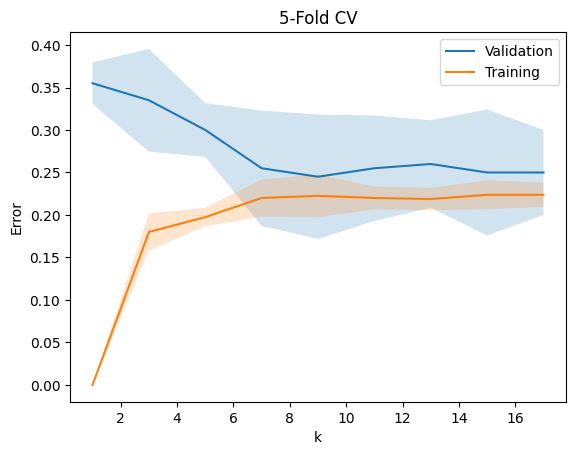

In [90]:
# plot the errors with K

fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_title(f"{num_folds}-Fold CV")
ax.set_ylabel("Error")
ax.set_xlabel("k")
ax.legend()

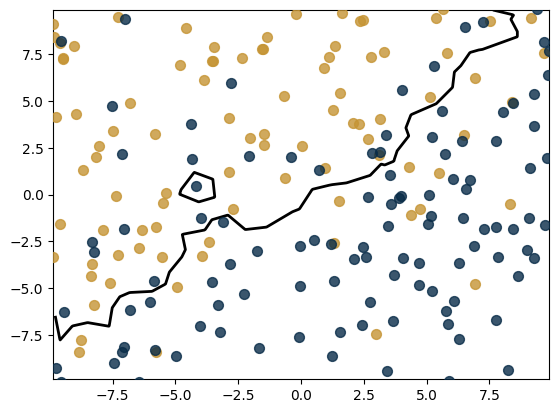

In [91]:
# Plot separatingFkNN on the TRAINING SET
separatingFkNN(Xtr, Ytr, best_k, Xtr)

**Dataset 4 (low noise)**

In [101]:
# Use k-fold CV to find best k for dataset 4 (low noise)
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

In [97]:
# TODO: Find the best k on the test set of dataset 4
best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr, Ytr, num_folds, k_list)
print(f"The best k chosen with {num_folds} folds is {best_k} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

The best k chosen with 5 folds is 9 with error 6.50 +- 3.00%


In [98]:
# Sanity check - Computing the test error
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, Xte), Yte)
print(f'The test error with k={best_k} is {test_error * 100:.2f}%')

The test error with k=9 is 7.00%


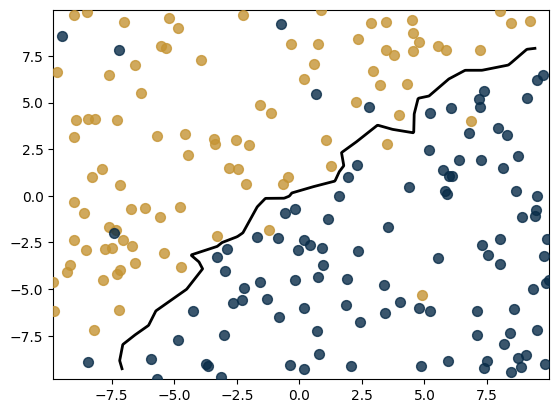

In [99]:
# Plot separatingFkNN
separatingFkNN(Xtr, Ytr, best_k, Xtr)

Now select the best K using only Xtr but without K-fold, as already did at the beginning of the notebook. What do you observe?
How does noise affect the best k?

 


In [113]:
# Use k-fold CV to find best k for dataset 4 (low noise)
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

k_tr_errors = []
k_list = range(1, 19, 1)

for current_k in k_list:
    Ypred = kNNClassify(Xtr, Ytr, current_k, Xtr)
    current_tr_err =  calcError(Ypred, Ytr)
    k_tr_errors.append(current_tr_err)
    
best_k =  np.argsort(k_tr_errors)[0] + 1 # since the index start from 0 each k is one value higher the its index

print(f"The best k chosen with the training-set is: {best_k}\n"
      f"with training error {np.min(k_tr_errors)*100:.2f}%")

# Sanity check - Computing the test error
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, Xte), Yte)
print(f'The test error with k={best_k} is {test_error * 100:.2f}%')

The best k chosen with the training-set is: 1
with training error 0.00%
The test error with k=1 is 12.00%


In [111]:
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training3.dat", "./Material/Classification/Test3.dat")

k_tr_errors = []
k_list = range(1, 31, 1)

for current_k in k_list:
    Ypred = kNNClassify(Xtr, Ytr, current_k, Xtr)
    current_tr_err =  calcError(Ypred, Ytr)
    k_tr_errors.append(current_tr_err)
    
best_k =  np.argsort(k_tr_errors)[0] + 1 # since the index start from 0 each k is one value higher the its index

print(f"The best k chosen with the training-set is: {best_k}\n"
      f"with training error {np.min(k_tr_errors)*100:.2f}%")

# Sanity check - Computing the test error
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, Xte), Yte)
print(f'The test error with k={best_k} is {test_error * 100:.2f}%')

The best k chosen with the training-set is: 1
with training error 0.00%
The test error with k=1 is 33.50%


When using the training set wihtout cross-validation, for both datasets, the best k will always be 1 since the training error is always lowest and leads to model memorizing the training dataset and overfitting. Therefore, it doesn't matter how much noise the dataset has it will choses lowest k since it has the lower training error.
In the sanity check, as it was predictible since the noise is much higher in dataset 3, the test error is much more compared to the dataset 4 which has low noise.

### Now using the best K found before to evaluate the model on a new Test set. Create the test set using the functions defined in the Lab0

In [118]:

n = 200 # number of points per class
D = 2 # dimension of the points

# linear case
m = 0.9
q = 0

# bounds (assume they are the same for all dimensions)
low_D = -10
high_D = 10

new_xtest, new_ytest = linearBinaryClass(n, low_D, high_D, m, q)

# loading dataset3 
Xtr, Ytr, _, _ = load_dataset(
    "./Material/Classification/Training3.dat", "./Material/Classification/Test3.dat")
best_k = 9 # best-k from cross-validation
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, new_xtest), new_ytest)
print(f'The test error with k={best_k} is {test_error * 100:.2f}% for dataset3')

best_k = 1 # best-k from choosing the k with lowest training error
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, new_xtest), new_ytest)
print(f'The test error with k={best_k} is {test_error * 100:.2f}% for dataset3')

# loading dataset4
Xtr, Ytr, _, _ = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")
best_k = 9 # best-k from cross-validation
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, new_xtest), new_ytest)
print(f'The test error with k={best_k} is {test_error * 100:.2f}% for dataset4')

best_k = 1 # best-k from choosing the k with lowest training error
test_error = calcError(kNNClassify(Xtr, Ytr, best_k, new_xtest), new_ytest)
print(f'The test error with k={best_k} is {test_error * 100:.2f}% for dataset4')

The test error with k=9 is 6.00% for dataset3
The test error with k=1 is 19.00% for dataset3
The test error with k=9 is 3.50% for dataset4
The test error with k=1 is 7.00% for dataset4



#### WRITE HERE THE OBSERVATIONS FOR THIS LAB
for the dataset 3 which has higher noise the best-k found by the Cross-validation has lower training error and for the dataset 4 that has lower noise the same goes by. Therefore, we can conclude that for both high and lose noise dataset having the best-k with cross-validation performs better. 
